<a href="https://colab.research.google.com/github/irfanshahmayeen/GR-08-CSE-445-Machine-Learnling-Stop-Sign-Detection-In-The-Street-/blob/Irfan/Gradient_Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [2]:
from google.colab import drive
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from skimage.feature import hog, local_binary_pattern
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from scipy.ndimage import rotate
from skimage import exposure
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive


In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


# Convert Stop Sign Images


In [4]:
source_folder_stop ="/content/drive/MyDrive/CSE445/Project/Stop sign"
destination_folder_stop = "/content/drive/MyDrive/CSE445/Dataset/Stop sign"

if not os.path.exists(destination_folder_stop):
    os.makedirs(destination_folder_stop)

png_files_stop = [f for f in os.listdir(source_folder_stop) if f.lower().endswith(".png")]
png_files_stop.sort()

for index, file in enumerate(png_files_stop, start=1):
    img_path = os.path.join(source_folder_stop, file)
    img = Image.open(img_path)
    rgb_img = img.convert("RGB")
    new_filename = f"{index}.jpg"
    save_path = os.path.join(destination_folder_stop, new_filename)
    rgb_img.save(save_path, "JPEG")
    print(f"Saved Stop Sign: {save_path}")

print("Stop sign conversion complete!")


Saved Stop Sign: /content/drive/MyDrive/CSE445/Dataset/Stop sign/1.jpg
Saved Stop Sign: /content/drive/MyDrive/CSE445/Dataset/Stop sign/2.jpg
Saved Stop Sign: /content/drive/MyDrive/CSE445/Dataset/Stop sign/3.jpg
Saved Stop Sign: /content/drive/MyDrive/CSE445/Dataset/Stop sign/4.jpg
Saved Stop Sign: /content/drive/MyDrive/CSE445/Dataset/Stop sign/5.jpg
Saved Stop Sign: /content/drive/MyDrive/CSE445/Dataset/Stop sign/6.jpg
Saved Stop Sign: /content/drive/MyDrive/CSE445/Dataset/Stop sign/7.jpg
Saved Stop Sign: /content/drive/MyDrive/CSE445/Dataset/Stop sign/8.jpg
Saved Stop Sign: /content/drive/MyDrive/CSE445/Dataset/Stop sign/9.jpg
Saved Stop Sign: /content/drive/MyDrive/CSE445/Dataset/Stop sign/10.jpg
Saved Stop Sign: /content/drive/MyDrive/CSE445/Dataset/Stop sign/11.jpg
Saved Stop Sign: /content/drive/MyDrive/CSE445/Dataset/Stop sign/12.jpg
Saved Stop Sign: /content/drive/MyDrive/CSE445/Dataset/Stop sign/13.jpg
Saved Stop Sign: /content/drive/MyDrive/CSE445/Dataset/Stop sign/14.jpg
S

# Convert Non Stop Sign Images


In [6]:
source_folder_non = "/content/drive/MyDrive/CSE445/Project/Non stop sign"
destination_folder_non = "/content/drive/MyDrive/CSE445 project/Dataset/Non stop sign"

if not os.path.exists(destination_folder_non):
    os.makedirs(destination_folder_non)

png_files_non = [f for f in os.listdir(source_folder_non) if f.lower().endswith(".png")]
png_files_non.sort()

for index, file in enumerate(png_files_non, start=1):
    img_path = os.path.join(source_folder_non, file)
    img = Image.open(img_path)
    rgb_img = img.convert("RGB")
    new_filename = f"{index}.jpg"
    save_path = os.path.join(destination_folder_non, new_filename)
    rgb_img.save(save_path, "JPEG")
    print(f"Saved Non Stop Sign: {save_path}")

print("Non stop sign conversion complete!")

Saved Non Stop Sign: /content/drive/MyDrive/CSE445/Dataset/Non stop sign/1.jpg
Saved Non Stop Sign: /content/drive/MyDrive/CSE445/Dataset/Non stop sign/2.jpg
Saved Non Stop Sign: /content/drive/MyDrive/CSE445/Dataset/Non stop sign/3.jpg
Saved Non Stop Sign: /content/drive/MyDrive/CSE445/Dataset/Non stop sign/4.jpg
Saved Non Stop Sign: /content/drive/MyDrive/CSE445/Dataset/Non stop sign/5.jpg
Saved Non Stop Sign: /content/drive/MyDrive/CSE445/Dataset/Non stop sign/6.jpg
Saved Non Stop Sign: /content/drive/MyDrive/CSE445/Dataset/Non stop sign/7.jpg
Saved Non Stop Sign: /content/drive/MyDrive/CSE445/Dataset/Non stop sign/8.jpg
Saved Non Stop Sign: /content/drive/MyDrive/CSE445/Dataset/Non stop sign/9.jpg
Saved Non Stop Sign: /content/drive/MyDrive/CSE445/Dataset/Non stop sign/10.jpg
Saved Non Stop Sign: /content/drive/MyDrive/CSE445/Dataset/Non stop sign/11.jpg
Saved Non Stop Sign: /content/drive/MyDrive/CSE445/Dataset/Non stop sign/12.jpg
Saved Non Stop Sign: /content/drive/MyDrive/CSE44

# Load Dataset


In [7]:
dataset_path = "/content/drive/MyDrive/CSE445/Dataset"
categories = ["Non stop sign", "Stop sign"]
IMG_SIZE = 64

data = []
labels = []
original_images = []

for label, category in enumerate(categories):
    folder_path = os.path.join(dataset_path, category)
    image_files = os.listdir(folder_path)
    print(f"Number of {category} images: {len(image_files)}")
    for filename in image_files:
        img_path = os.path.join(folder_path, filename)
        try:
            img_original = cv2.imread(img_path)
            if img_original is None:
                print(f"Failed to load: {img_path}")
                continue
            original_images.append(img_original)
            img = cv2.resize(img_original, (IMG_SIZE, IMG_SIZE))
            data.append(img)
            labels.append(label)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

data = np.array(data)
labels = np.array(labels)

print(f"Class distribution: Non stop sign: {np.sum(labels == 0)}, Stop sign: {np.sum(labels == 1)}")

Number of Non stop sign images: 65
Number of Stop sign images: 56
Class distribution: Non stop sign: 65, Stop sign: 56


# Data Augmentation


In [8]:
min_samples = min(np.sum(labels == 0), np.sum(labels == 1))
balanced_data = []
balanced_labels = []
balanced_originals = []

for label in [0, 1]:
    indices = np.where(labels == label)[0]
    np.random.shuffle(indices)
    selected_indices = indices[:min_samples]
    balanced_data.extend(data[selected_indices])
    balanced_labels.extend(labels[selected_indices])
    balanced_originals.extend([original_images[i] for i in selected_indices])

augmented_data = []
augmented_labels = []
augmented_originals = []

for img, label, orig_img in zip(balanced_data, balanced_labels, balanced_originals):
    augmented_data.append(img)
    augmented_labels.append(label)
    augmented_originals.append(orig_img)

    for angle in [-15, -10, 10, 15]:
        rotated = rotate(img, angle, reshape=False, mode='nearest')
        rotated = (rotated * 255).astype(np.uint8)
        augmented_data.append(rotated)
        augmented_labels.append(label)
        augmented_originals.append(rotated)

    bright = cv2.convertScaleAbs(img, beta=30)
    augmented_data.append(bright)
    augmented_labels.append(label)
    augmented_originals.append(bright)

    dark = cv2.convertScaleAbs(img, beta=-30)
    augmented_data.append(dark)
    augmented_labels.append(label)
    augmented_originals.append(dark)

    low_contrast = exposure.adjust_gamma(img, gamma=0.8)
    augmented_data.append(low_contrast)
    augmented_labels.append(label)
    augmented_originals.append(low_contrast)

    high_contrast = exposure.adjust_gamma(img, gamma=1.2)
    augmented_data.append(high_contrast)
    augmented_labels.append(label)
    augmented_originals.append(high_contrast)

    if label == 1:
        flipped = cv2.flip(img, 1)
        augmented_data.append(flipped)
        augmented_labels.append(label)
        augmented_originals.append(flipped)

data = np.array(augmented_data)
labels = np.array(augmented_labels)
original_images = augmented_originals

print(f"Augmented dataset shape: {data.shape}")
print(f"Augmented class distribution: Non stop sign: {np.sum(labels == 0)}, Stop sign: {np.sum(labels == 1)}")

Augmented dataset shape: (1064, 64, 64, 3)
Augmented class distribution: Non stop sign: 504, Stop sign: 560


# Visualize Sample Images


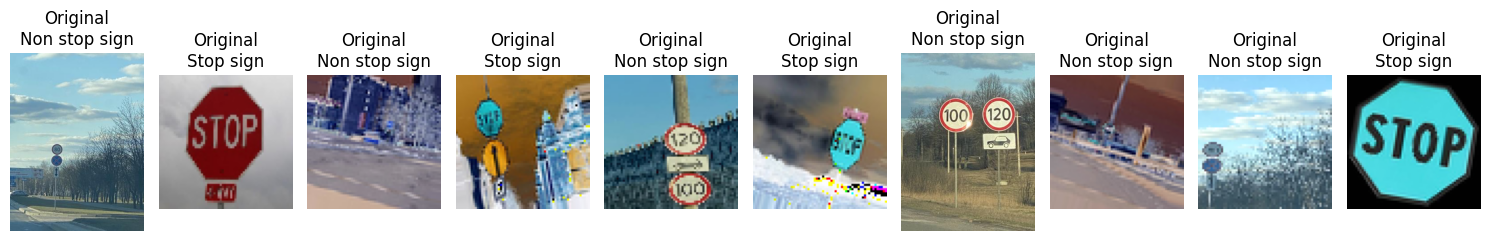

In [9]:
num_images = 10
random_indices = np.random.choice(len(original_images), num_images, replace=False)

plt.figure(figsize=(15, 3))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_images, i + 1)
    original_rgb = cv2.cvtColor(original_images[idx], cv2.COLOR_BGR2RGB)
    plt.imshow(original_rgb)
    plt.title(f"Original\n{categories[labels[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Feature Extraction


In [10]:
def extract_shape_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_contours = len(contours)
    largest_area = 0
    num_sides = 0
    is_circular = 0
    aspect_ratio = 1.0
    convexity = 0
    solidity = 0
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        largest_area = cv2.contourArea(largest_contour)
        epsilon = 0.01 * cv2.arcLength(largest_contour, True)
        approx = cv2.approxPolyDP(largest_contour, epsilon, True)
        num_sides = len(approx)
        perimeter = cv2.arcLength(largest_contour, True)
        if perimeter > 0:
            circularity = 4 * np.pi * largest_area / (perimeter * perimeter)
            is_circular = 1 if circularity > 0.8 else 0
        x, y, w, h = cv2.boundingRect(largest_contour)
        aspect_ratio = float(w) / h if h > 0 else 1.0
        hull = cv2.convexHull(largest_contour)
        hull_area = cv2.contourArea(hull)
        if hull_area > 0:
            convexity = float(largest_area) / hull_area
            solidity = largest_area / hull_area
    return np.array([
        num_contours,
        largest_area / (IMG_SIZE * IMG_SIZE),
        num_sides,
        is_circular,
        aspect_ratio,
        convexity,
        solidity
    ])

def extract_color_features(img):
    color_features = []
    for i in range(3):
        channel = img[:, :, i]
        hist = np.histogram(channel, bins=32, range=(0, 256))[0]
        if hist.sum() > 0:
            hist = hist / hist.sum()
        color_features.extend(hist)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    for i in range(3):
        channel = hsv[:, :, i]
        hist = np.histogram(channel, bins=16, range=(0, 256))[0]
        if hist.sum() > 0:
            hist = hist / hist.sum()
        color_features.extend(hist)
    b, g, r = cv2.split(img)
    total = np.sum(r) + np.sum(g) + np.sum(b)
    red_ratio = np.sum(r) / total if total > 0 else 0
    color_features.append(red_ratio)
    return np.array(color_features)

features = []
for img in data:
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = img_gray / 255.0
    hog_feat = hog(img_gray,
                   pixels_per_cell=(6, 6),
                   cells_per_block=(2, 2),
                   orientations=9,
                   feature_vector=True)
    color_feat = extract_color_features(img)
    lbp_features = []
    for radius in [1, 2]:
        lbp = local_binary_pattern(img_gray * 255, P=8, R=radius, method='uniform')
        lbp_hist, _ = np.histogram(lbp, bins=26, range=(0, 26), density=True)
        lbp_features.extend(lbp_hist)
    shape_feat = extract_shape_features(img)
    combined_features = np.concatenate([hog_feat, color_feat, lbp_features, shape_feat])
    features.append(combined_features)

X_features = np.array(features)
print("Feature extraction completed. Shape:", X_features.shape)

Feature extraction completed. Shape: (1064, 3120)


# Train-Test Split


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_features, labels, test_size=0.2, random_state=42, stratify=labels)
X_full_indices = np.arange(len(X_features))
X_train_indices, X_test_indices = train_test_split(X_full_indices, test_size=0.2, random_state=42, stratify=labels)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")
print(f"Training set label distribution: {np.bincount(y_train)} (0: Non stop, 1: Stop)")
print(f"Testing set label distribution: {np.bincount(y_test)} (0: Non stop, 1: Stop)")

Training samples: 851, Testing samples: 213
Training set label distribution: [403 448] (0: Non stop, 1: Stop)
Testing set label distribution: [101 112] (0: Non stop, 1: Stop)


# Feature Preprocessing


In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Gradient Boosting-Specific Code ---


In [17]:
from sklearn.ensemble import GradientBoostingClassifier

print("\n--- Gradient Boosting Model ---")
gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    min_samples_split=5,
    random_state=42
)
gb_model.fit(X_train_scaled, y_train)
gb_y_pred = gb_model.predict(X_test_scaled)

gb_accuracy = accuracy_score(y_test, gb_y_pred)
print(f"Gradient Boosting Accuracy: {gb_accuracy:.4f}")
print("\nGradient Boosting Classification Report:")
print(classification_report(y_test, gb_y_pred, target_names=categories))


--- Gradient Boosting Model ---
Gradient Boosting Accuracy: 1.0000

Gradient Boosting Classification Report:
               precision    recall  f1-score   support

Non stop sign       1.00      1.00      1.00       101
    Stop sign       1.00      1.00      1.00       112

     accuracy                           1.00       213
    macro avg       1.00      1.00      1.00       213
 weighted avg       1.00      1.00      1.00       213



# Confusion Matrix


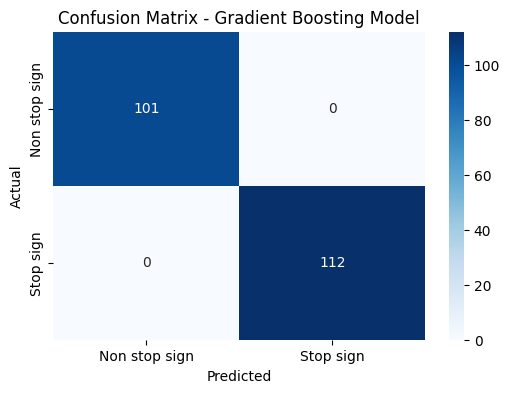

In [18]:
cm = confusion_matrix(y_test, gb_y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix - Gradient Boosting Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Visualize Test Results


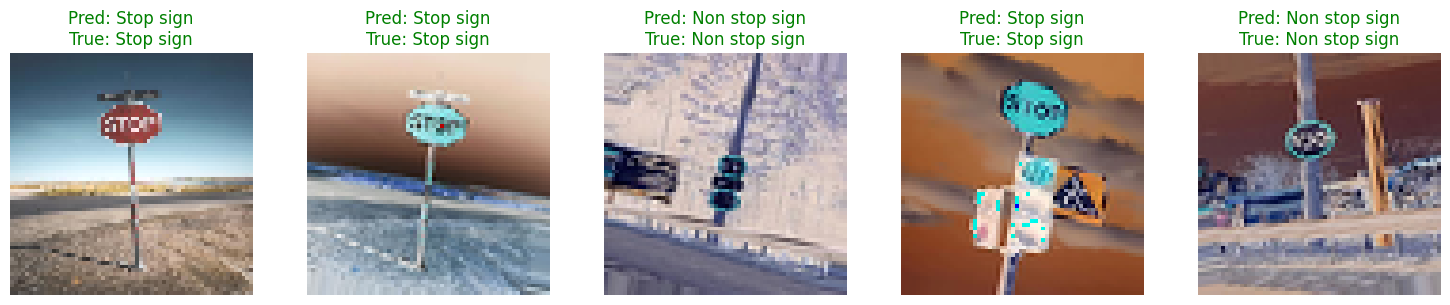

In [19]:
num_samples = 5
test_indices = np.random.choice(len(X_test), num_samples, replace=False)

plt.figure(figsize=(15, 3))
for i, idx in enumerate(test_indices):
    orig_idx = X_test_indices[idx]
    plt.subplot(1, num_samples, i + 1)
    original_rgb = cv2.cvtColor(original_images[orig_idx], cv2.COLOR_BGR2RGB)
    plt.imshow(original_rgb)
    pred_label = categories[gb_y_pred[idx]]
    true_label = categories[y_test[idx]]
    color = 'green' if pred_label == true_label else 'red'
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Prediction Function for Gradient Boosting


In [20]:
def predict_stop_sign(image_path, true_label=None):
    if image_path.lower().endswith('.png'):
        img = Image.open(image_path).convert('RGB')
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    else:
        img = cv2.imread(image_path)

    if img is None:
        print(f"Error: Could not load image at {image_path}")
        return None

    plt.figure(figsize=(3, 3))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if true_label:
        plt.title(f"Test Image (True: {true_label})")
    else:
        plt.title("Test Image")
    plt.axis('off')
    plt.show()

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = img_gray / 255.0
    hog_feat = hog(img_gray,
                   pixels_per_cell=(6, 6),
                   cells_per_block=(2, 2),
                   orientations=9,
                   feature_vector=True)
    color_feat = extract_color_features(img)
    lbp_features = []
    for radius in [1, 2]:
        lbp = local_binary_pattern(img_gray * 255, P=8, R=radius, method='uniform')
        lbp_hist, _ = np.histogram(lbp, bins=26, range=(0, 26), density=True)
        lbp_features.extend(lbp_hist)
    shape_feat = extract_shape_features(img)
    img_features = np.concatenate([hog_feat, color_feat, lbp_features, shape_feat])
    img_features_scaled = scaler.transform([img_features])

    probabilities = gb_model.predict_proba(img_features_scaled)[0]
    prediction = gb_model.predict(img_features_scaled)[0]
    threshold = 0.4
    final_prediction = 1 if probabilities[1] > threshold else 0

    print(f"Prediction: {categories[final_prediction]}")
    print(f"Confidence scores: Non stop sign: {probabilities[0]:.2f}, Stop sign: {probabilities[1]:.2f}")
    if true_label:
        print(f"True label: {true_label}")
        print(f"Correct: {categories[final_prediction] == true_label}")

    return categories[final_prediction]

# Test with Multiple Images



Testing image: /content/drive/MyDrive/CSE445/Test images/Stop sign/1.jpg


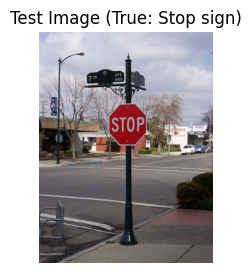

Prediction: Stop sign
Confidence scores: Non stop sign: 0.03, Stop sign: 0.97
True label: Stop sign
Correct: True
Final Prediction: Stop sign


In [22]:
test_images = [
    ("/content/drive/MyDrive/CSE445/Test images/Stop sign/1.jpg", "Stop sign"),
]

for test_image, true_label in test_images:
    print(f"\nTesting image: {test_image}")
    result = predict_stop_sign(test_image, true_label)
    if result:
        print("Final Prediction:", result)

# Model Performance Summary


In [27]:
print("\n--- Gradient Boosting Model Performance Summary ---")
print(f"Gradient Boosting Accuracy: {gb_accuracy*100:.2f}%")
print("\nClassification Report:")
# Convert classification report to percentages
report = classification_report(y_test, gb_y_pred, target_names=categories, output_dict=True)
for category in categories:
    print(f"{category}:")
    print(f"  Precision: {report[category]['precision']*100:.2f}%")
    print(f"  Recall: {report[category]['recall']*100:.2f}%")
    print(f"  F1-score: {report[category]['f1-score']*100:.2f}%")
print(f"Macro avg:")
print(f"  Precision: {report['macro avg']['precision']*100:.2f}%")
print(f"  Recall: {report['macro avg']['recall']*100:.2f}%")
print(f"  F1-score: {report['macro avg']['f1-score']*100:.2f}%")
print(f"Weighted avg:")
print(f"  Precision: {report['weighted avg']['precision']*100:.2f}%")
print(f"  Recall: {report['weighted avg']['recall']*100:.2f}%")
print(f"  F1-score: {report['weighted avg']['f1-score']*100:.2f}%")


--- Gradient Boosting Model Performance Summary ---
Gradient Boosting Accuracy: 100.00%

Classification Report:
Non stop sign:
  Precision: 100.00%
  Recall: 100.00%
  F1-score: 100.00%
Stop sign:
  Precision: 100.00%
  Recall: 100.00%
  F1-score: 100.00%
Macro avg:
  Precision: 100.00%
  Recall: 100.00%
  F1-score: 100.00%
Weighted avg:
  Precision: 100.00%
  Recall: 100.00%
  F1-score: 100.00%
